In [ ]:
! pip install matplotlib pandas seaborn
! pip install statsmodels
! pip install pytest
! pip install numpy nibabel nilearn neuroimagingtools
! pip install rsatoolbox
! pip install PcmPy
! pip install h5py
! pip install mat73

In [19]:
import scipy.io as sio
import h5py
import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
import pandas as pd
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools as nt
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from pathlib import Path
import seaborn as sns
import PcmPy as pcm
import glob
import matplotlib.patches as patches


# SET PATHS:
# baseDir = '/Users/alighavam/Desktop/Projects/bimanual_wrist/data/fMRI'
baseDir = '/Users/alighavampour/Desktop/Projects/bimanual_wrist/data/fMRI'
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'


## Time Series per run

In [33]:
glm = 3
region = 1
pre_idx = 8
post_idx = 21
participants = [7]

def extract_snippets(y, pre, post, onsets):
        snippets_y = []
        
        for onset in onsets:
            onset_frame = np.round(onset).astype(int) # the fMRI volume closest to the onset time
            # onset_frame = np.round(onset).astype(int) - 1  # in python, the index starts from 0, so we need to subtract 1

            start_idx = onset_frame - pre # <pre> volumes before the onset
            end_idx = onset_frame + post # <post> volumes after the onset

            snippet_y = np.full(pre + post + 1, np.nan) # nan fill the snippet
            
            valid_start = int(max(0, start_idx)) # make sure the start index is not negative
            valid_end = int(min(len(y), end_idx + 1)) # make sure the end index is not out of bounds
            
            insert_start = int(valid_start - start_idx) # where to start inserting the data
            insert_end = int(insert_start + (valid_end - valid_start)) # where to end inserting the data

            snippet_y[insert_start:insert_end] = y[valid_start:valid_end] # insert the data into the snippet
            
            snippets_y.append(snippet_y)
                
        return np.array(snippets_y)

for sn in participants:
    # load participant info:
    pinfo = pd.read_table(os.path.join(baseDir, 'participants.tsv'))
    numTR = int(pinfo[pinfo['sn']==sn]['numTR'].values[0])
    runs = pinfo[pinfo['sn']==sn]['glm_runs'].values[0]
    runs = [int(run) for run in runs.split('.')]
    
    roi_names = ['', 'S1', 'M1', 'PMd', 'PMv', 'SMA', 'V1', 'SPLa', 'SPLp']
    
    D = pd.read_table(os.path.join(baseDir, behavDir, f's{sn:02d}', f'BimanualWrist_MR_{sn}.dat'))
    T = sio.loadmat(os.path.join(baseDir, regDir, f's{sn:02d}', f'time_series_glm{glm}.mat'), simplify_cells=True)
    
    # SPM = mat73.loadmat(os.path.join(baseDir, f'glm{glm}', f's{sn:02d}', 'SPM.mat'))
    f = h5py.File(os.path.join(baseDir, f'glm{glm}', f's{sn:02d}', 'SPM.mat'), 'r')
    SPM = f['SPM']

    X = SPM['xX']['X'][()].T
    y_adj = T['y_adj']
    y_hat = T['y_hat']
    y_run_avg = np.zeros(numTR)
    y_hat_avg = np.zeros(numTR)
    for i, run in enumerate(runs):
        # getting the rows of the run from the SPM:
        refs = SPM['Sess']['row'][()]
        row = SPM[refs.flatten()[i]][()].flatten().astype(int) - 1
        
        t = np.arange(0, len(row), 1)
        ons = D[D['BN']==run]['startTimeReal'].values.flatten()/1000

        fig, ax = plt.subplots(1, 1, figsize=(20, 4))
        ax.vlines(ons, ymin=min(y_adj[row, region]), ymax=max(y_adj[row, region]), colors='b', lw=0.5, alpha=0.7, linestyles='--')
        plt.plot(t, y_hat[row, region], color='r', lw=1.5)
        plt.plot(t, y_adj[row, region], color='k', lw=1)
        plt.xlabel('time (s)')
        plt.ylabel('y adj')
        plt.xlim((t[0]-2, t[-1]+2))
        plt.title(f'run {run} - glm{glm}, region: {roi_names[region]}')
        plt.tight_layout()
        plt.savefig(f'./figures/bmw_time_s{sn:02d}_glm{glm}_run{run:02d}_{roi_names[region]}.pdf', bbox_inches="tight")
        plt.close()
        y_run_avg += y_adj[row, region]/len(runs)
        y_hat_avg += y_hat[row, region]/len(runs)
    
    '''
    ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
    TIME LOCKING AND AVERAGING THE TIME SERIES 
    ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
    '''
    # load the events:
    events = pd.read_table(os.path.join(baseDir, behavDir, f's{sn:02d}', f'glm{glm}_events.tsv'))

    # find the onsets of the events:
    # T = events.copy()
    # T['y_adj'] = np.nan
    # T['y_hat'] = np.nan
    T = pd.DataFrame()
    
    blocks = runs
    for r in range(np.shape(y_adj)[1]): # loop over regions
        for i, BN in enumerate(blocks):
            tmp = pd.DataFrame()

            # getting the rows of the run from SPM.mat:
            refs = SPM['Sess']['row'][()]
            row = SPM[refs.flatten()[i]][()].flatten().astype(int) - 1
            
            y_adj_reg = y_adj[row, r]
            y_hat_reg = y_hat[row, r]

            # onsets are time relative to t=0 which alings with = 1. So, we need to subtract 1 to get the volume correpsonding to the onset.
            onsets = np.round(events[events['BN']==BN]['onset'].values.flatten())
             
            y_adj_cut = extract_snippets(y_adj_reg, pre_idx, post_idx, onsets)
            y_hat_cut = extract_snippets(y_hat_reg, pre_idx, post_idx, onsets)

            tmp = pd.concat([tmp, events[events['BN']==BN]], axis=1).reset_index(drop=True)
            tmp['region'] = r

            col_names = [f"y_adj{i}" for i in range(y_adj_cut.shape[1])]
            df_y_adj = pd.DataFrame(y_adj_cut, columns=col_names)
            tmp = pd.concat([tmp, df_y_adj], axis=1).reset_index(drop=True)

            col_names = [f"y_hat{i}" for i in range(y_hat_cut.shape[1])]
            df_y_hat = pd.DataFrame(y_hat_cut, columns=col_names)
            tmp = pd.concat([tmp, df_y_hat], axis=1).reset_index(drop=True)
            
            T = pd.concat([T, tmp], axis=0).reset_index(drop=True)

    T.to_csv(os.path.join(baseDir, regDir, f's{sn:02d}', f'bmw_time_series_cut_glm{glm}.csv'), index=False)


## Time series time lock to stimulus onset

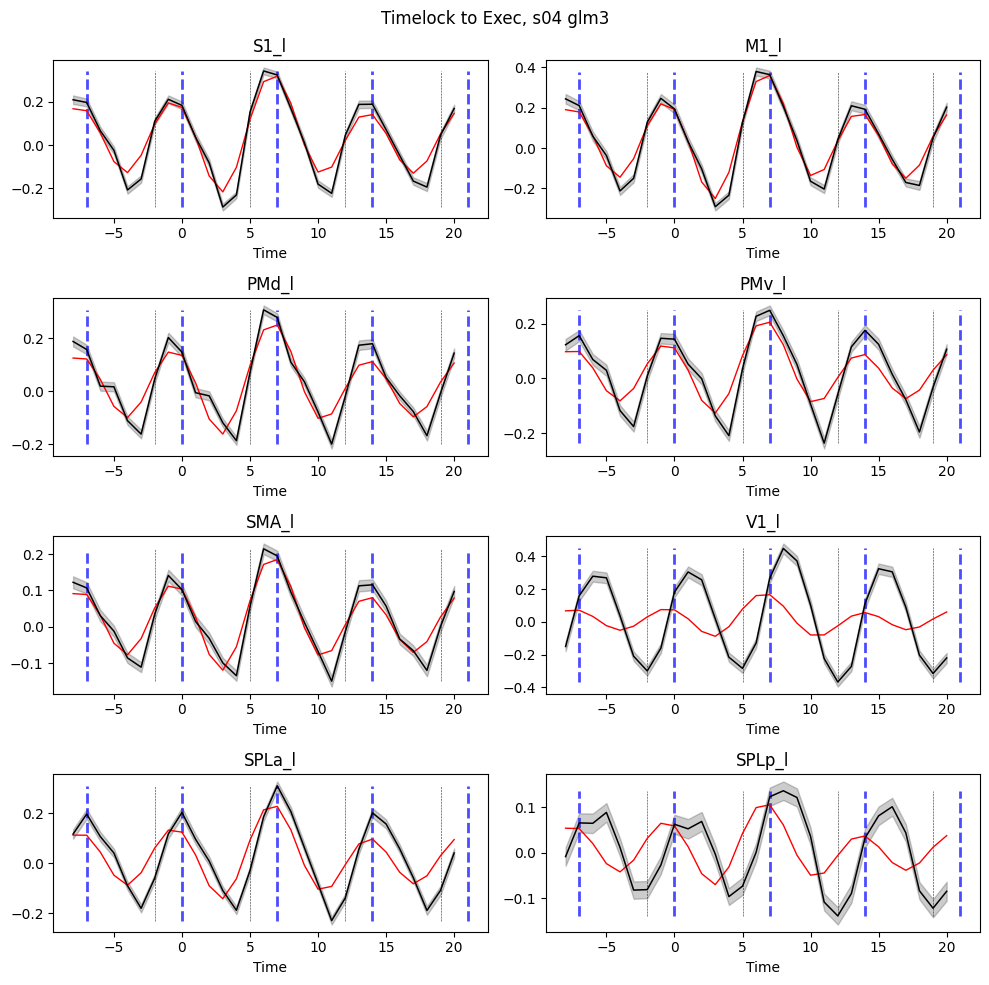

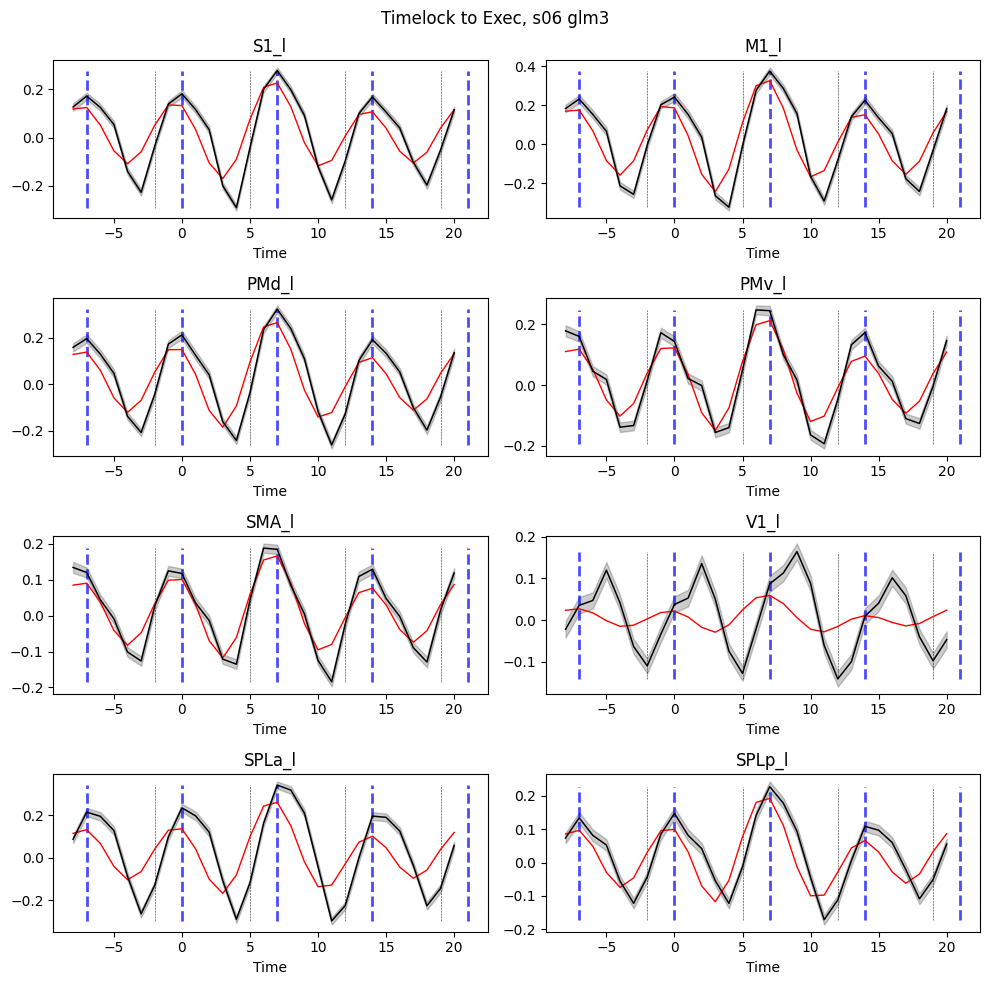

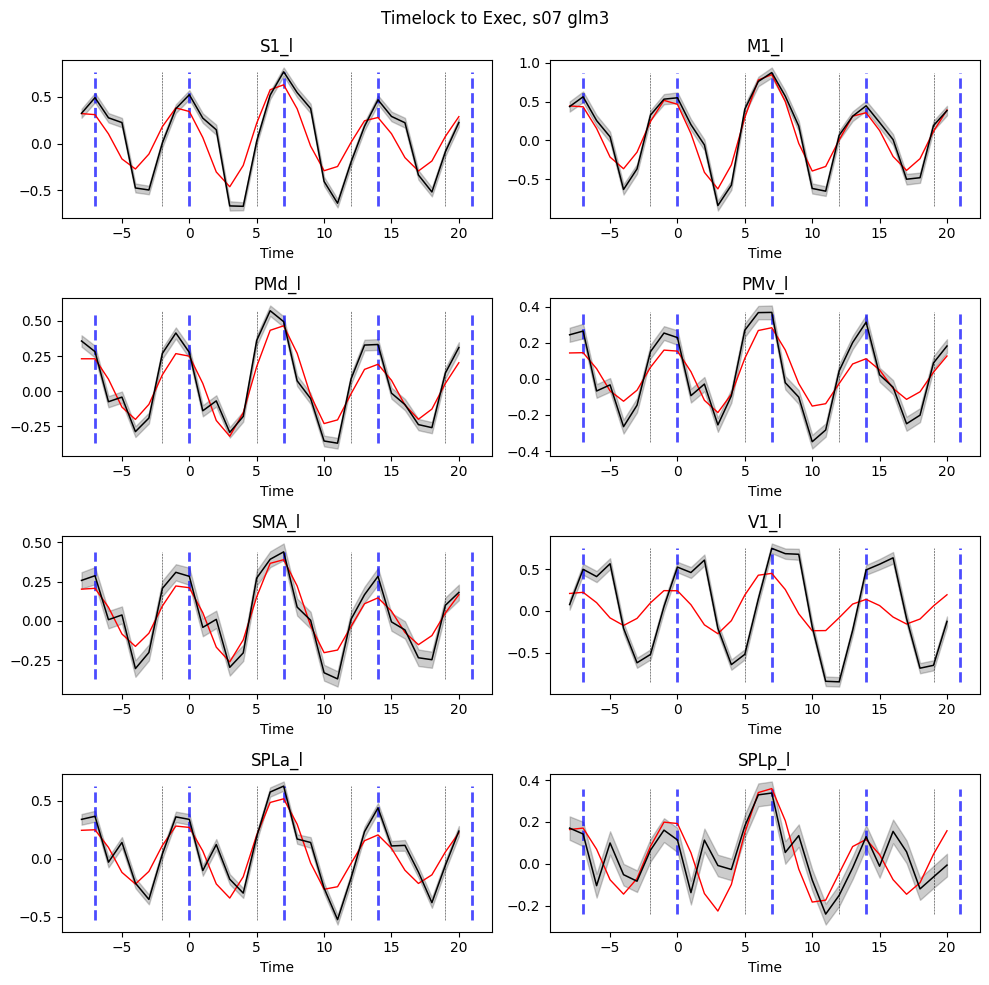

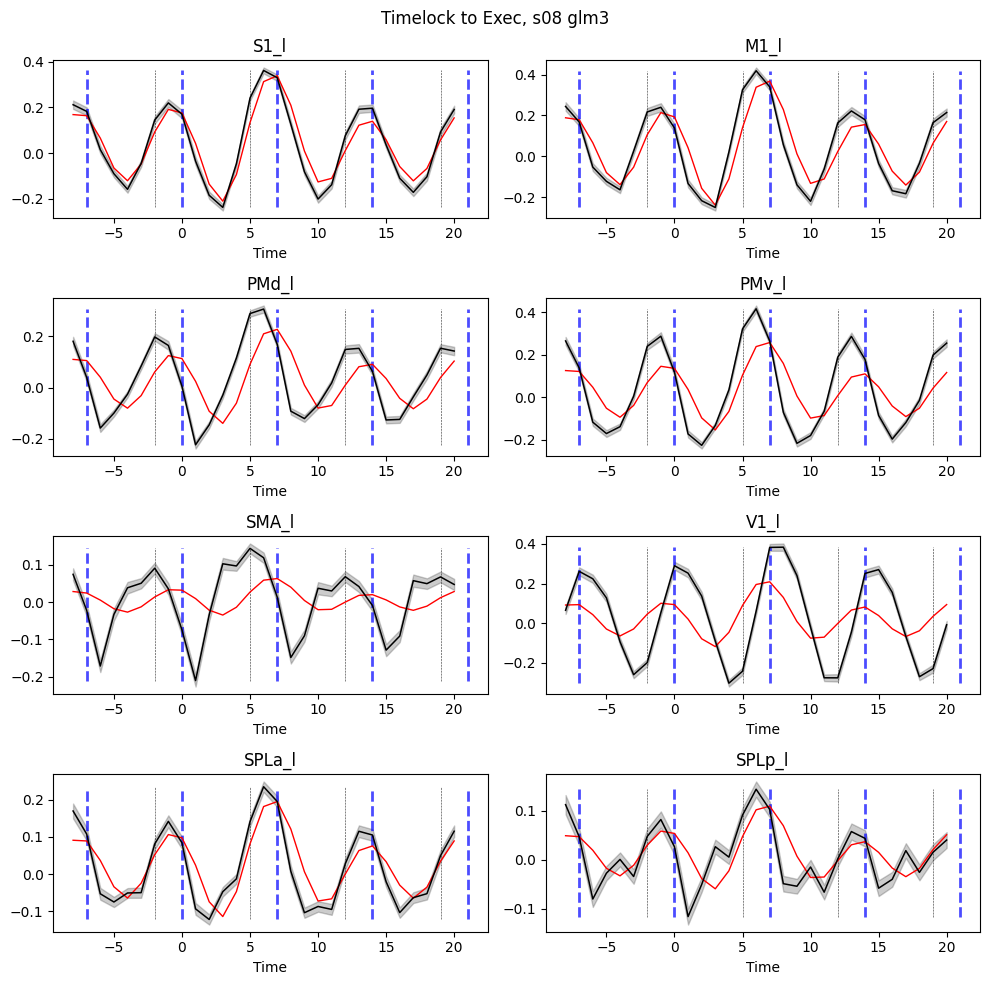

In [32]:
glm = 3
pre_idx = 8
post_idx = 21
participants = [4,6,7,8]

for sn in participants:
    T = pd.read_csv(os.path.join(baseDir, regDir, f's{sn:02d}', f'bmw_time_series_cut_glm{glm}.csv'))
    pinfo = pd.read_table(os.path.join(baseDir, 'participants.tsv'))
    TR = pinfo['TR'].values[0]/1000

    t = np.arange(-pre_idx, post_idx, TR)
    roi_names = ['_l', 'S1_l', 'M1_l', 'PMd_l', 'PMv_l', 'SMA_l', 'V1_l', 'SPLa_l', 'SPLp_l', '_r', 'S1_r', 'M1_r', 'PMd_r', 'PMv_r', 'SMA_r', 'V1_r', 'SPLa_r', 'SPLp_r']

    n_row = 4
    n_col = 2
    fig, axes = plt.subplots(n_row, n_col, figsize=(10, 10))
    for j, r in enumerate(range(1,9)): # loop over regions
        y_adj = T.loc[T['region']==r, [f'y_adj{i}' for i in range(len(t))]].mean().to_list()
        y_adj_sem = T.loc[T['region']==r, [f'y_adj{i}' for i in range(len(t))]].sem().to_list()

        y_hat = T.loc[T['region']==r, [f'y_hat{i}' for i in range(len(t))]].mean().to_list()

        ax = axes[j//n_col, j%n_col]
        ax.vlines([-7,0,7,14,21], ymin=min(min(y_adj),min(y_hat)), ymax=max(max(y_adj),max(y_hat)), color='b', ls='--', lw=2, alpha=0.7)
        ax.vlines([-2,5,12,19], ymin=min(min(y_adj),min(y_hat)), ymax=max(max(y_adj),max(y_hat)), color='k', ls='--', lw=0.4, alpha=0.85)
        ax.plot(t, y_hat, color='r', lw=1)
        ax.plot(t, y_adj, color='k', lw=1.1)
        ax.fill_between(t, np.array(y_adj)-np.array(y_adj_sem), np.array(y_adj)+np.array(y_adj_sem), color='k', alpha=0.2)
        ax.set_title(f'{roi_names[r]}')
        ax.set_xlabel('Time')
        
    fig.suptitle(f'Timelock to Exec, s{sn:02d} glm{glm}')
    plt.tight_layout()
    plt.savefig(f'./figures/bmw_timelock_s{sn:02d}_glm{glm}.pdf', bbox_inches="tight")
    plt.show()
